** Data Collection and Cleaning **

The tweets were collected and partially preprocessed by the R script (collectTweets.R).
Each retweet count has been normalized by the number of followers for the Twitter user.

In [1]:
### for file IO:
import os
import codecs

### for data analysis:
import numpy as np
import pandas as pd

### for text cleaning & preprocessing:
import re
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

### for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

### for vectorizing text & training ML algorithms:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib # for pickling the pipeline

from __future__ import print_function # use print as a function like in python3

NameError: name 'matplotlib' is not defined

First, set the working directory, and load in the data:

In [ ]:
# Define work_dir as the current working directory
os.chdir(work_dir)
filename = 'tweets_w_pctRT0918to25_rmNL.csv'

with codecs.open(filename, "r",encoding='utf-8', errors='ignore') as fdata:
    DT = pd.read_csv(fdata)

** Define functions to clean and tokenize tweet text data **

In [30]:
stop = stopwords.words('english')
# [w for w in tokenizer_porter('a runner likes running and runs a lot')[-10:] if w not in stop]

# print stop

def rmURL(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    return tweet

def rmMARK(tweet):
    tweet = rmURL(tweet)
    #Convert @username to ATusername
    tweet = re.sub('@','AT',tweet)
    #Replace # with HASH_TAG
    tweet = re.sub('#', 'HASH', tweet)
    #Temporarily store emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', tweet)
    #Remove all non-word charactersand add the emoticons to 
    # the end of the processed document string
    # remove emoticon nose to be consistent
    tweet = re.sub('[\W]+', ' ', tweet) + ' ' + \
            ' '.join(emoticons).replace('-', '')
    #trim
    tweet = tweet.strip('\'"')
    return tweet

def tweetCleaner(tweet):
    tweet = rmURL(tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Replace # with HASH_TAG
    tweet = re.sub('#', 'HASH_TAG ', tweet)
    #Temporarily store emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', tweet)
    #Remove all non-word charactersand add the emoticons to 
    # the end of the processed document string
    # remove emoticon nose to be consistent
    tweet = re.sub('[\W]+', ' ', tweet) + ' ' + \
            ' '.join(emoticons).replace('-', '')
    #trim
    tweet = tweet.strip('\'"')
    return tweet

def rmURLtokenizer(tweet):
    tweet = rmURL(tweet)
    tw = [w for w in tweet.split() if w not in stop]
    return tw

def rmMARKtokenizer(tweet):
    tweet = rmMARK(tweet)
    tw = [w for w in tweet.split() if w not in stop]
    return tw

def tweetTokenizer(tweet):
    tweet = tweetCleaner(tweet)
    tw = [w for w in tweet.split() if w not in stop]
    return tw

porter = PorterStemmer()
def rmURL_porter(text):
    return [porter.stem(word) for word in rmURLtokenizer(text)]

def rmMARK_porter(text):
    return [porter.stem(word) for word in rmMARKtokenizer(text)]

def tokenizer_porter(text):
    return [porter.stem(word) for word in tweetTokenizer(text)]

** Exploratory Data Analysis **

Distribution of retweets (retweet percentage suggest that only about 1% of all tweets are retweeted, --not enough data for regression analysis of retweet counts.

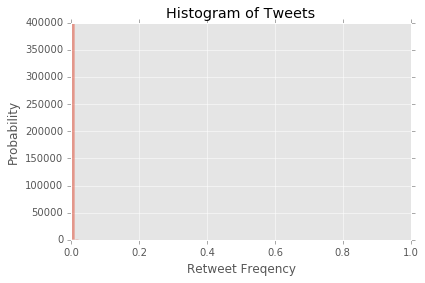

In [29]:
fig, ax = plt.subplots()
DT.pctRT.hist(ax=ax, bins=100, alpha=0.5, range=[0, 1])
#ax.set_xscale('log')
plt.xlabel('Retweet Freqency')
plt.ylabel('Probability')
plt.title('Histogram of Tweets')

# Save the plot
img = 'distribution.png'
plt.tight_layout()
plt.savefig(img, format='png',  dpi=300)

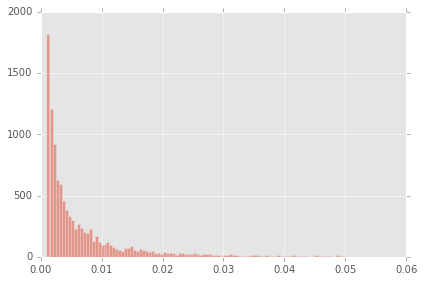

In [31]:
fig, ax = plt.subplots()
DT.pctRT.hist(ax=ax, bins=100, alpha=0.5, range=[0.001, 0.05])
#ax.set_xscale('log')
img = 'distribution_zoom.png'
plt.tight_layout()
plt.savefig(img, format='png',  dpi=300)

** Turn it into a Classification problem **

Construct categorical tweets -- 0: Not Retweeted; 1: Retweeted with a threshold (0.5%)

Notice the class imbalance. The percentage of positive class (retweeted) is only about 1% of all tweets:

In [49]:
print( float(sum(DT.pctRT > 0.005))/df.shape[0] )

0.0118829890861


Subsample Tweets that were not retweeted to roughly match the total number of tweets that were retweeted, so that the two categories have the same sample size.

In [34]:
df = pd.DataFrame({"tweet": df.tweet, "RTbinary": (df.pctRT > 0.005).astype(int)})

pos = df.ix[df['RTbinary'] == 1]
neg = df.ix[df['RTbinary'] == 0]

negtrain = neg.sample(n=10000-len(pos), random_state = 0)
negtest = neg.drop(negtrain.index)

df = pos.append(negtrain)

In [35]:
# Ramdom Shuffling:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

In [36]:
tweets = df['tweet'].values
texts = []
tokes = []
for i in range(len(tweets)):
    texts.append(tweetCleaner(tweets[i]))
    tokes.append(tokenizer_porter(tweets[i]))
    
df['cleanTweet'] = texts
df['tokenTweet'] = tokes

Save the cleaned tweet data to hard disk, which is the data file used for training and testing the logistic regression with stochastic gradient descent:

In [41]:
dfClean = pd.DataFrame({"RTbinary": df.RTbinary, "cleanTweet": df.cleanTweet})
dfClean.to_csv("rtBinaryClean.csv", index=False, header=False)

Split the roughly balanced dataset into train and test datasets:

In [37]:
train = df.sample(frac=0.8,random_state=200)
test = df.drop(train.index)

X_train = train.tweet.values
y_train = train.RTbinary.values
X_test = test.tweet.values
y_test = test.RTbinary.values

Use Scikit Learn GridSearch and Cross-validatoin to optimize the TFxIDF vectorization parameters including N-gram range, stopword list, tokenization, stemming, as well as logistic regression penalty and regularization. 

In [17]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

param_grid = [
    {'vect__ngram_range': [(1,2),(1,3)],
     'vect__stop_words': [stop, None],
     'vect__tokenizer': [rmURLtokenizer, rmMARKtokenizer, tweetTokenizer, 
                         rmURL_porter, rmMARK_porter, tokenizer_porter],
     'clf__penalty': ['l1', 'l2'],
     'clf__C': [1.0, 10.0, 100.0]},
    {'vect__ngram_range': [(1,2),(1,3)],
     'vect__stop_words': [stop, None],
     'vect__tokenizer': [rmURLtokenizer, rmMARKtokenizer, tweetTokenizer, 
                         rmURL_porter, rmMARK_porter, tokenizer_porter],
     'vect__use_idf':[False],
     'vect__norm':[None],
     'clf__penalty': ['l1', 'l2'],
     'clf__C': [1.0, 10.0, 100.0]}
]

lr_tfidf = Pipeline([ ('vect', tfidf), ('clf', LogisticRegression(random_state=0)) ])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy',
                           cv=5, verbose=1, n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 27.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tru...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 2), (1, 3)], 'vect__tokenizer': [<function rmURLtokenizer at 0x7f711d8a4b18>, <function rmMARKtokenizer at 0x7f711d8a4b90>, <function tweetTokenizer at 0x7f711d8a4c08>, <function rmURL_porter at 0x7f711d8a4c80>, <function rmMARK_porter at 0x7f711d8a4cf8>, <func...711d8a4d70>], 'vect__use_idf': [False], 'clf__C': [1.0, 10.0, 100.0], 'clf__penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1

Print out the best parameter set and accuracy on the test dataset (compared to the random chance):

In [18]:
print('Best parameter set: %s' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

pct = float(sum(y_test))/len(y_test)
print('Random Chance Accuracy in Test Set: %.3f' % pct)

Best parameter set: {'vect__ngram_range': (1, 3), 'vect__tokenizer': <function tokenizer_porter at 0x7f711d8a4d70>, 'vect__stop_words': [u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'w

Best parameter set is the same for a number of different train/test split creterion (i.e., pctRT > 0.005 or pctRT >0):

{'vect__ngram_range': (1, 3), 'vect__tokenizer': <function tweetTokenizer at 0x7f48b3a5dc08>, 'clf__penalty': 'l2', 'clf__C': 100.0, 'vect__stop_words': [u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u'not', u'only', u'own', u'same', u'so', u'than', u'too', u'very', u's', u't', u'can', u'will', u'just', u'don', u'should', u'now', u'd', u'll', u'm', u'o', u're', u've', u'y', u'ain', u'aren', u'couldn', u'didn', u'doesn', u'hadn', u'hasn', u'haven', u'isn', u'ma', u'mightn', u'mustn', u'needn', u'shan', u'shouldn', u'wasn', u'weren', u'won', u'wouldn']}


CV Accuracy: 0.750

Test Accuracy: 0.751

Random Chance Accuracy in Test Set: 0.490


Combine the test dataset with the unused tweets from the negative class to form an imbalanced dataset to test the performance of the model:

In [20]:
test_all = test.append(negtest)
print( test_all.shape )# total tweets
print( sum(test_all['RTbinary']) )# number of retweeted tweets

(374102, 4)
980


In [21]:
# Ramdom Shuffling:
np.random.seed(999)
test_all = test_all.reindex(np.random.permutation(test_all.index))

In [22]:
X_test = test_all.tweet.values
y_test = test_all.RTbinary.values
y_pred = clf.predict(X_test)

Plot confusion matrix to check the sensitivity and specificity of the classifier:

In [42]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title, fontsize = 18)
    plt.colorbar()
    tick_marks = [0,1] #np.arange(len(iris.target_names))
    plt.xticks(tick_marks, fontsize = 14) #(tick_marks, iris.target_names, rotation=45)
    plt.yticks(tick_marks, fontsize = 14) # (tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True Labels', fontsize = 16)
    plt.xlabel('Predicted Labels', fontsize= 16)

Compute Confusion Matrix:

In [43]:
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels)

Since the samples in the testset are highly imbalanced, i.e., only 0.3% tweets were retweeted, we should look at the normalized confusion matrix:

Normalized confusion matrix
[[ 0.81  0.19]
 [ 0.26  0.74]]


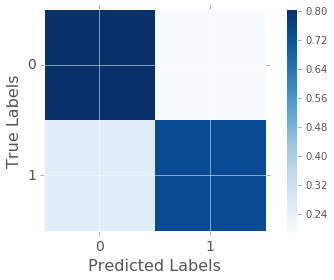

In [44]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
img = 'normCM.png'
plt.tight_layout()
plt.savefig(img, format='png',  dpi=600)
plt.show()

Pickle the pipeline into one file using joblib:

In [68]:
joblib.dump(clf, 'classifier_alterMed_logit.pkl', compress = 1)

['clf.pkl']